# GPM1839-10 Waterfall

The code below allows for the creation of a waterfall plot based on the raw data from the 2022-07-20T19:11:58 burst from GPM1839-10.

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
plt.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
plt.rc('mathtext',**{'default':'regular'})
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

## Loading raw data

The raw data for the waterfall plot can be found in the files "source_beam.npy.gz" and "reference_beam.npy.gz". These file contain partially time and frequency integrated versions of the data recorded with APSUSE on 2022-07-20. The source beam file contains data from the beam closest to GPM1839-10s position during the observation while the reference beam contains data from the beam furtherst GPM1839-10s position during the observation. Manual unzipping of the files with gunzip is required before executing the code below.

In [32]:
# Data parameters
channel_width = 544e6 / 64  # frequency resolution in Hertz
tres = 0.0038550528  # time resolution in seconds

# Below are the explicit frequencies, in Hz, of each channel in order
channel_freqs = np.array(
      [1.08348438e+09, 1.07498438e+09, 1.06648438e+09, 1.05798438e+09,
       1.04948438e+09, 1.04098438e+09, 1.03248438e+09, 1.02398438e+09,
       1.01548438e+09, 1.00698438e+09, 9.98484375e+08, 9.89984375e+08,
       9.81484375e+08, 9.72984375e+08, 9.64484375e+08, 9.55984375e+08,
       9.47484375e+08, 9.38984375e+08, 9.30484375e+08, 9.21984375e+08,
       9.13484375e+08, 9.04984375e+08, 8.96484375e+08, 8.87984375e+08,
       8.79484375e+08, 8.70984375e+08, 8.62484375e+08, 8.53984375e+08,
       8.45484375e+08, 8.36984375e+08, 8.28484375e+08, 8.19984375e+08,
       8.11484375e+08, 8.02984375e+08, 7.94484375e+08, 7.85984375e+08,
       7.77484375e+08, 7.68984375e+08, 7.60484375e+08, 7.51984375e+08,
       7.43484375e+08, 7.34984375e+08, 7.26484375e+08, 7.17984375e+08,
       7.09484375e+08, 7.00984375e+08, 6.92484375e+08, 6.83984375e+08,
       6.75484375e+08, 6.66984375e+08, 6.58484375e+08, 6.49984375e+08,
       6.41484375e+08, 6.32984375e+08, 6.24484375e+08, 6.15984375e+08,
       6.07484375e+08, 5.98984375e+08, 5.90484375e+08, 5.81984375e+08,
       5.73484375e+08, 5.64984375e+08, 5.56484375e+08, 5.47984375e+08])

# Load data and convert to masked array for later
source_beam = np.ma.masked_array(np.load("source_beam.npy"))
reference_beam = np.ma.masked_array(np.load("reference_beam.npy"))

## Cleaning the data

In order to clean the data for plotting, two techniques are used. The first is to subtract the furthest beam from the source from the nearest beam from the source. The RFI and baselines in these beams are highly correlated while the astrophysical signal has only a small correlation. Some small amount of the astrophysiscal signal will be removed at this stage. The second technique is to perform a simple per-channel median subtraction.

In addition to these techniques, known RFI-affected channels are masked.

In [33]:
def subtract_median(data):
    cdata = np.ma.copy(data)
    for ii, chan in enumerate(cdata):
        cdata[ii] = chan - np.ma.median(chan)
    return cdata

data = subtract_median((source_beam - reference_beam).T)
data.mask = np.zeros_like(data)
data.mask[0:2,:] = True
data.mask[14:19,:] = True
data.mask[61:,:] = True

## Generating the plot

To generate the waterfall plot requires first that we create a dedipsersed version of the cleaned data. Here we use a simple routine that rolls each channel in the array by the dispersive delay at that frequency (w.r.t. the top of the band).

<IPython.core.display.Javascript object>


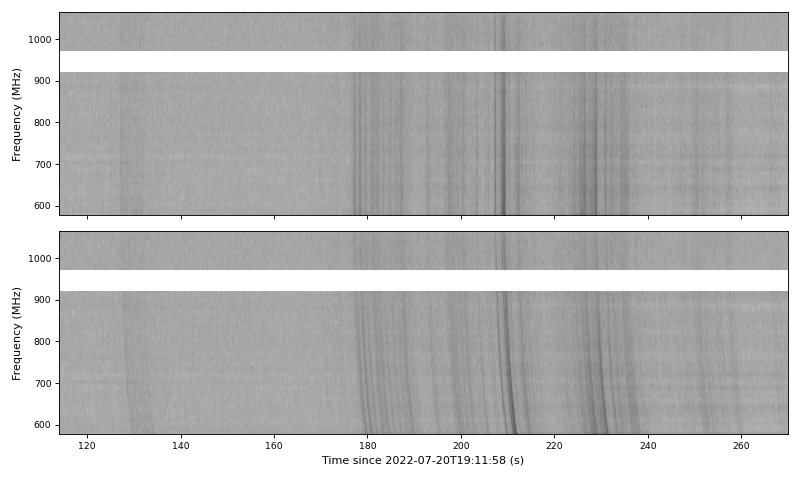

In [34]:
def dedisperse(data, freqs, tres, dm):
    out = np.ma.copy(data)
    for ii, freq in enumerate(freqs):
        delay = round((4.15e3 * (1/(freq/1e6)**2 - 1/(freqs[0]/1e6)**2) * dm) / tres)
        out[ii] = np.roll(out[ii], -1*delay)
    return np.ma.masked_array(out, mask=data.mask)

# Nominal burst dispersion measure
dm = 273.5  # pc / ccm

data_0dm = dedisperse(data, channel_freqs, tres, 0.0)
data_273dm = dedisperse(data, channel_freqs, tres, 273.5)

# Arguments for imshow
plot_args = dict(
    extent = [0, data.shape[1]*tres, channel_freqs[-1]/1e6, channel_freqs[0]/1e6],
    aspect='auto', 
    cmap='Greys'
)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[10,6], sharey=True, sharex=True)
# Zero DM plot
axs[1].imshow(dedisperse(data, channel_freqs, tres, 0.0), **plot_args)
axs[1].set_ylabel("Frequency (MHz)")
# Nominal DM plot
axs[0].imshow(dedisperse(data, channel_freqs, tres, 273.5), **plot_args)
axs[0].set_ylabel("Frequency (MHz)")

# Resize to avoid band edges and to zoom into pulse window
plt.ylim(577.3, 1065)
plt.xlim(114, 270)
plt.xlabel("Time since 2022-07-20T19:11:58 (s)")
plt.tight_layout()

In [30]:
plt.savefig("waterfall.pdf")